In [84]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF,LatentDirichletAllocation,PCA
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.cluster import KMeans,DBSCAN,MiniBatchKMeans
import spacy 
import nltk
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
import re 
import random

In [3]:
nlp = spacy.load("en_core_web_lg")

In [4]:
df = pd.read_csv("npr.csv")
df.head()

,Article
0,"In the Washington of 2016, even when the polic..."
1,Donald Trump has used Twitter — his prefe...
2,Donald Trump is unabashedly praising Russian...
3,"Updated at 2:50 p. m. ET, Russian President Vl..."
4,"From photography, illustration and video, to d..."


In [42]:
def process(txt):
    txt = re.sub("[^A-Za-z]"," ",txt)
    txt = re.sub(r"(?:\s)([A-Za-z])\s+([A-Za-z])\s+", r" \1\2 ", txt)
    txt = re.sub("\s+\w\s+"," ",txt)
    txt = re.sub("\s+"," ",txt)
    txt = txt.lower().strip()
    doc = nlp(txt)
    rt = []
    c = 0
    for token in doc:
        if not(token.is_stop or token.is_oov or token.is_space):
            rt.append(token.lemma_)
            c += 1
    return " ".join(rt), c

In [43]:
x = df["Article"].apply(process)

In [65]:
df = pd.concat((x.apply(lambda x: x[0]),x.apply(lambda x: x[1])),axis=1)

In [68]:
df.columns = ["article","length"]

In [69]:
df.head()

,article,length
0,washington policy bipartisan politic sense yea...,613
1,donald trump twitter preferred mean communicat...,315
2,donald trump unabashedly praise russian presid...,429
3,update pm et russian president vladimir putin ...,212
4,photography illustration video datum visualiza...,882


## Data Visualization

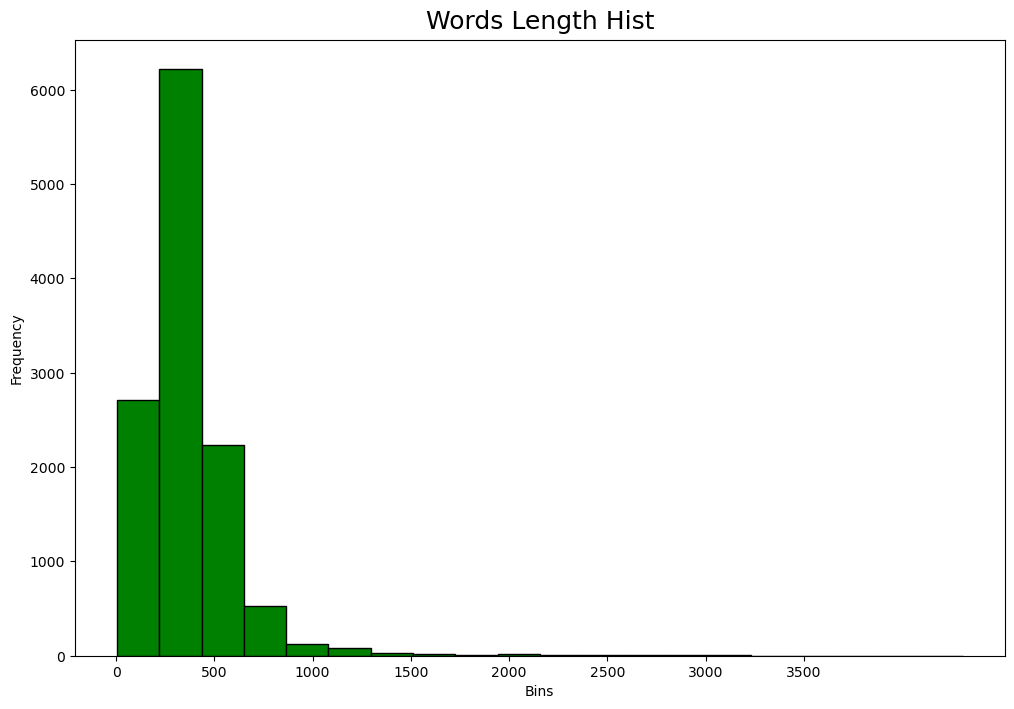

In [73]:
plt.figure(figsize=(12,8))
plt.title("Words Length Hist",pad=8,fontsize=18)
plt.hist(df["length"],bins=20,edgecolor="black",color="green")
plt.xlabel("Bins")
plt.ylabel("Frequency")
plt.xticks(range(0,4000,500))
plt.show()

Histogram is right skewed so we conclude that the median lays below 500

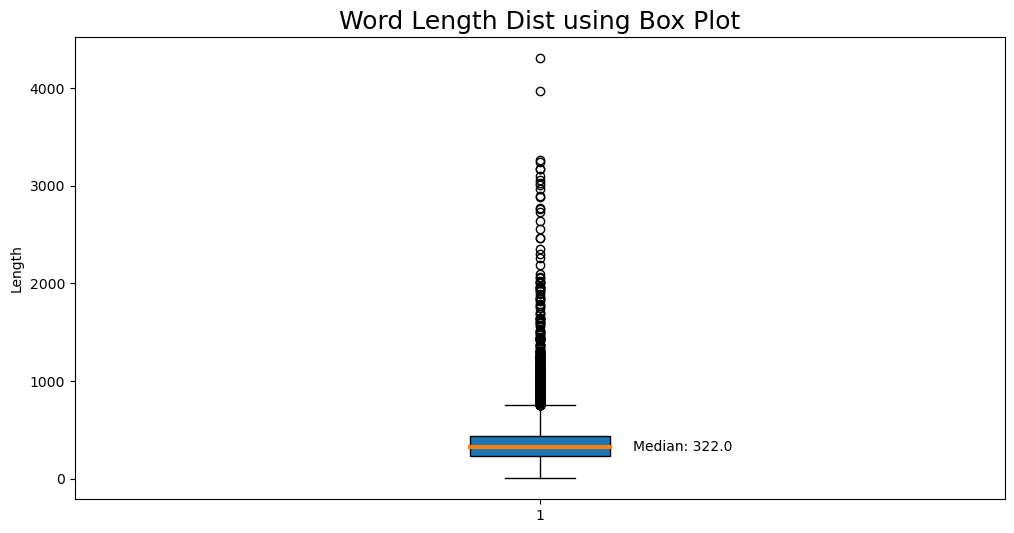

In [78]:
plt.figure(figsize=(12,6))
plt.title("Word Length Dist using Box Plot",fontsize=18)
plt.boxplot(df["length"],patch_artist=True,medianprops={"linewidth":3})
plt.ylabel("Length")
plt.text(1.1,df["length"].median(),s=f"Median: {df['length'].median()}",va="center")
plt.show()

In [89]:
cv = CountVectorizer(min_df=2,max_df=0.95)
dtm1 = cv.fit_transform(df["article"])

In [90]:
n = len(cv.get_feature_names_out())
n

32856

In [92]:
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.95,
 'max_features': None,
 'min_df': 2,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [93]:
for i in range(15):
    x = random.randint(0,n)
    print(cv.get_feature_names_out()[x])

inactive
submerged
slime
tonight
tearful
primera
acquaint
st
enjoy
raindrop
topical
lawfully
hop
crust
yuma


In [95]:
tf = TfidfVectorizer(max_df=0.95,min_df=2)
dtm2 = tf.fit_transform(df["article"])

In [96]:
lda = LatentDirichletAllocation(n_components=7)
lda.fit(dtm1)

LatentDirichletAllocation(n_components=7)

In [97]:
lda.components_

array([[ 0.43250938,  4.71918416,  0.14288484, ...,  4.14248391,
         0.14286819,  0.14286445],
       [12.71001694,  0.14382606,  3.0487785 , ...,  0.14287538,
         0.14368099,  0.14285734],
       [ 0.20173378, 11.5178779 ,  0.14307497, ...,  0.14286485,
         4.04705678,  0.14288206],
       ...,
       [16.72433705,  0.1432851 ,  0.14375323, ...,  0.1430442 ,
         3.23712844,  0.14287811],
       [34.87552011,  0.14290018,  3.23557036, ...,  0.14297662,
         0.14328013,  0.14318712],
       [11.7869367 ,  0.19006946,  0.14285715, ...,  0.14288808,
         0.14300478,  0.14285714]])

In [98]:
print(lda.components_[0].argsort()[:10])

[24162 12577  6832  8985 10579  1596 18044 11367 31844 12373]


In [99]:
print(lda.components_[0].argsort()[-10:])

[17465  6435 20187 16384  4324 28994 21412 24255 22089 25459]


In [101]:
for i in range(len(lda.components_)):
    print(f"Cluster #{i}")
    print([cv.get_feature_names_out()[j] for j in lda.components_[i].argsort()[-15:]])
    print()
    print('-'*50)

Cluster #0
['state', 'city', 'year', 'attack', 'kill', 'man', 'court', 'officer', 'law', 'case', 'tell', 'people', 'report', 'police', 'say']

--------------------------------------------------
Cluster #1
['facebook', 'tell', 'like', 'day', 'news', 'information', 'year', 'time', 'city', 'report', 'new', 'water', 'company', 'people', 'say']

--------------------------------------------------
Cluster #2
['people', 'find', 'day', 'big', 'water', 'come', 'company', 'world', 'time', 'eat', 'new', 'like', 'year', 'food', 'say']

--------------------------------------------------
Cluster #3
['republican', 'go', 'come', 'candidate', 'time', 'year', 'song', 'like', 'music', 'campaign', 'new', 'win', 'say', 'clinton', 'trump']

--------------------------------------------------
Cluster #4
['program', 'doctor', 'medical', 'woman', 'disease', 'child', 'drug', 'percent', 'patient', 'year', 'study', 'care', 'people', 'health', 'say']

--------------------------------------------------
Cluster #5
['c

In [102]:
topics = lda.transform(dtm1)

In [103]:
topics.shape

(11992, 7)

In [104]:
topics[0].round(2)

array([0.  , 0.01, 0.  , 0.13, 0.  , 0.  , 0.86])

In [105]:
cl1 = topics.argmax(axis=1)

First four articles are political and that means that our clusters are right

In [106]:
df["cluster1"] = cl1
df.head()

,article,length,cluster1
0,washington policy bipartisan politic sense yea...,613,6
1,donald trump twitter preferred mean communicat...,315,6
2,donald trump unabashedly praise russian presid...,429,6
3,update pm et russian president vladimir putin ...,212,6
4,photography illustration video datum visualiza...,882,2


In [109]:
from warnings import filterwarnings 
filterwarnings("ignore")

In [111]:
km = KMeans(n_clusters=7,init="k-means++")
km.fit(dtm1)

KMeans(n_clusters=7)

In [113]:
km.predict(dtm1)[:20]

array([4, 4, 6, 1, 5, 1, 1, 5, 1, 5, 1, 1, 5, 1, 5, 1, 1, 5, 1, 4])

In [116]:
dtm1

<11992x32856 sparse matrix of type '<class 'numpy.int64'>'
	with 2695628 stored elements in Compressed Sparse Row format>

In [118]:
pca = PCA(n_components=2,svd_solver="arpack")
red1 = pca.fit_transform(dtm1)

In [119]:
pca = PCA(n_components=2)
cen = pca.fit_transform(km.cluster_centers_)

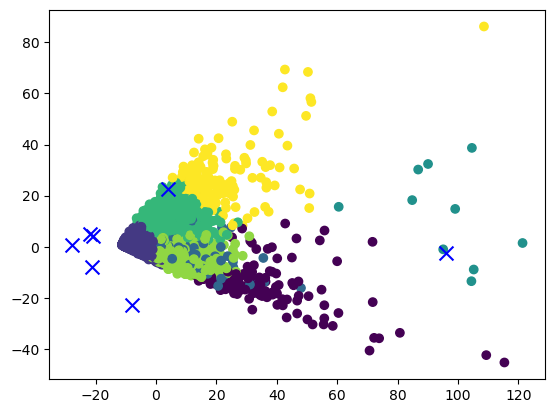

In [122]:
plt.scatter(red1[:,0], red1[:,1], c=km.predict(dtm1))
plt.scatter(cen[:, 0], cen[:,1], marker='x', s=100, c='blue')
plt.show()

Projection in 2D isn't the best way but our lda model did quite well

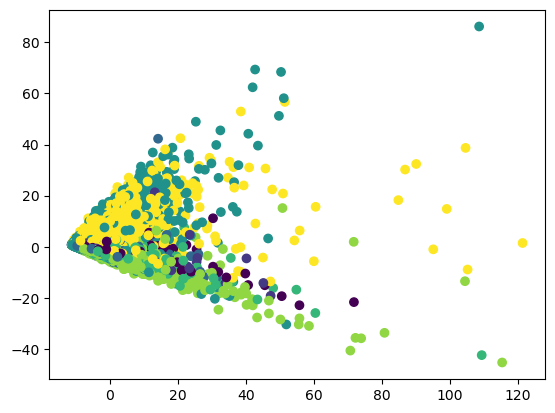

In [127]:
plt.scatter(red1[:,0], red1[:,1], c=df["cluster1"])
plt.show()

In [128]:
nmf = NMF(n_components=7)
nmf.fit(dtm2)

NMF(n_components=7)

In [130]:
nmf.components_

array([[0.00866385, 0.00180557, 0.00146552, ..., 0.00033545, 0.00156425,
        0.        ],
       [0.00024289, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00417482, 0.0015268 , 0.        , ..., 0.0001237 , 0.00040826,
        0.        ],
       ...,
       [0.00035176, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00049777, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00511537, 0.        , 0.00076526, ..., 0.        , 0.        ,
        0.00480372]])

In [131]:
for i in range(len(nmf.components_)):
    print(f"Cluster #{i}")
    print([tf.get_feature_names_out()[j] for j in nmf.components_[i].argsort()[-15:]])
    print()
    print('-'*50)

Cluster #0
['feel', 'way', 'book', 'work', 'want', 'time', 'life', 'thing', 'go', 'know', 'think', 'woman', 'like', 'people', 'say']

--------------------------------------------------
Cluster #1
['business', 'tweet', 'election', 'comey', 'russia', 'administration', 'republican', 'obama', 'white', 'donald', 'house', 'say', 'campaign', 'president', 'trump']

--------------------------------------------------
Cluster #2
['affordable', 'percent', 'obamacare', 'cost', 'drug', 'people', 'plan', 'coverage', 'bill', 'medicaid', 'patient', 'say', 'insurance', 'care', 'health']

--------------------------------------------------
Cluster #3
['president', 'official', 'isis', 'department', 'force', 'state', 'city', 'law', 'government', 'officer', 'court', 'attack', 'report', 'police', 'say']

--------------------------------------------------
Cluster #4
['primary', 'republican', 'election', 'delegate', 'party', 'hillary', 'democratic', 'win', 'candidate', 'campaign', 'state', 'voter', 'vote', 'san

In [133]:
topic_results = nmf.transform(dtm2)
topic_results.shape

(11992, 7)

In [134]:
topic_results[0].round(2)

array([0.  , 0.12, 0.  , 0.05, 0.02, 0.  , 0.  ])

In [135]:
topic_results.argmax(axis=1)

array([1, 1, 1, ..., 0, 4, 3], dtype=int64)

In [136]:
df["cluster2"] = topic_results.argmax(axis=1)
df.head(10)

,article,length,cluster1,cluster2
0,washington policy bipartisan politic sense yea...,613,6,1
1,donald trump twitter preferred mean communicat...,315,6,1
2,donald trump unabashedly praise russian presid...,429,6,1
3,update pm et russian president vladimir putin ...,212,6,1
4,photography illustration video datum visualiza...,882,2,3
5,want join yoga class hate beatific instructor ...,429,5,0
6,publicly support debunk claim vaccine cause au...,576,4,2
7,stand airport exit debate snack young man roun...,376,5,0
8,movie try realistic way summon batman shouldn ...,242,5,0
9,eighteen year ago new year eve david fisher vi...,650,5,0
